# Importing Libraries

In [1]:
# Basic Libraries for EDA and handling data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for standardising and spliting data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Libraries for supervised learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Libraries for unsupervised learning
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Libraries for visualising the resultant decision trees and plots
from sklearn.tree import plot_tree
from mlxtend.plotting import plot_decision_regions

# Libraries for measuring the accuracy of the trained models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score

# EDA

In [2]:
# Loading dataset
df = pd.read_csv('data.csv')
df.head()

,Pelvic Incidence,Pelvic Tilt,Lumbar Lordosis Angle,Sacral Slope,Pelvic Radius,Grade of Spondylolisthesis,Class
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [3]:
total_len = df.shape[0]
abnormal_len = df[df["Class"] == "AB"].shape[0]

print(f"Percentage of data in abnormal category: {(abnormal_len/total_len)*100:.2f}%")

Percentage of data in abnormal category: 67.74%


In [4]:
df["Class"].unique()

array(['AB', 'NO'], dtype=object)

In [5]:
df.loc[df["Class"]=='NO', "Class"] = 0 # Normal 
df.loc[df["Class"]=='AB', "Class"] = 1 # Abnormal

In [6]:
df["Class"] = df["Class"].astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Pelvic Incidence            310 non-null    float64
 1   Pelvic Tilt                 310 non-null    float64
 2   Lumbar Lordosis Angle       310 non-null    float64
 3   Sacral Slope                310 non-null    float64
 4   Pelvic Radius               310 non-null    float64
 5   Grade of Spondylolisthesis  310 non-null    float64
 6   Class                       310 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 17.1 KB


In [8]:
df.describe()

,Pelvic Incidence,Pelvic Tilt,Lumbar Lordosis Angle,Sacral Slope,Pelvic Radius,Grade of Spondylolisthesis,Class
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742,0.677419
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883,0.468220
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000,0.000000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000,0.000000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000,1.000000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000,1.000000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000,1.000000


In [9]:
print(df.isnull().sum()) # No missing values

Pelvic Incidence              0
Pelvic Tilt                   0
Lumbar Lordosis Angle         0
Sacral Slope                  0
Pelvic Radius                 0
Grade of Spondylolisthesis    0
Class                         0
dtype: int64


In [10]:
print(df.duplicated().sum())  # No duplicate entries

0


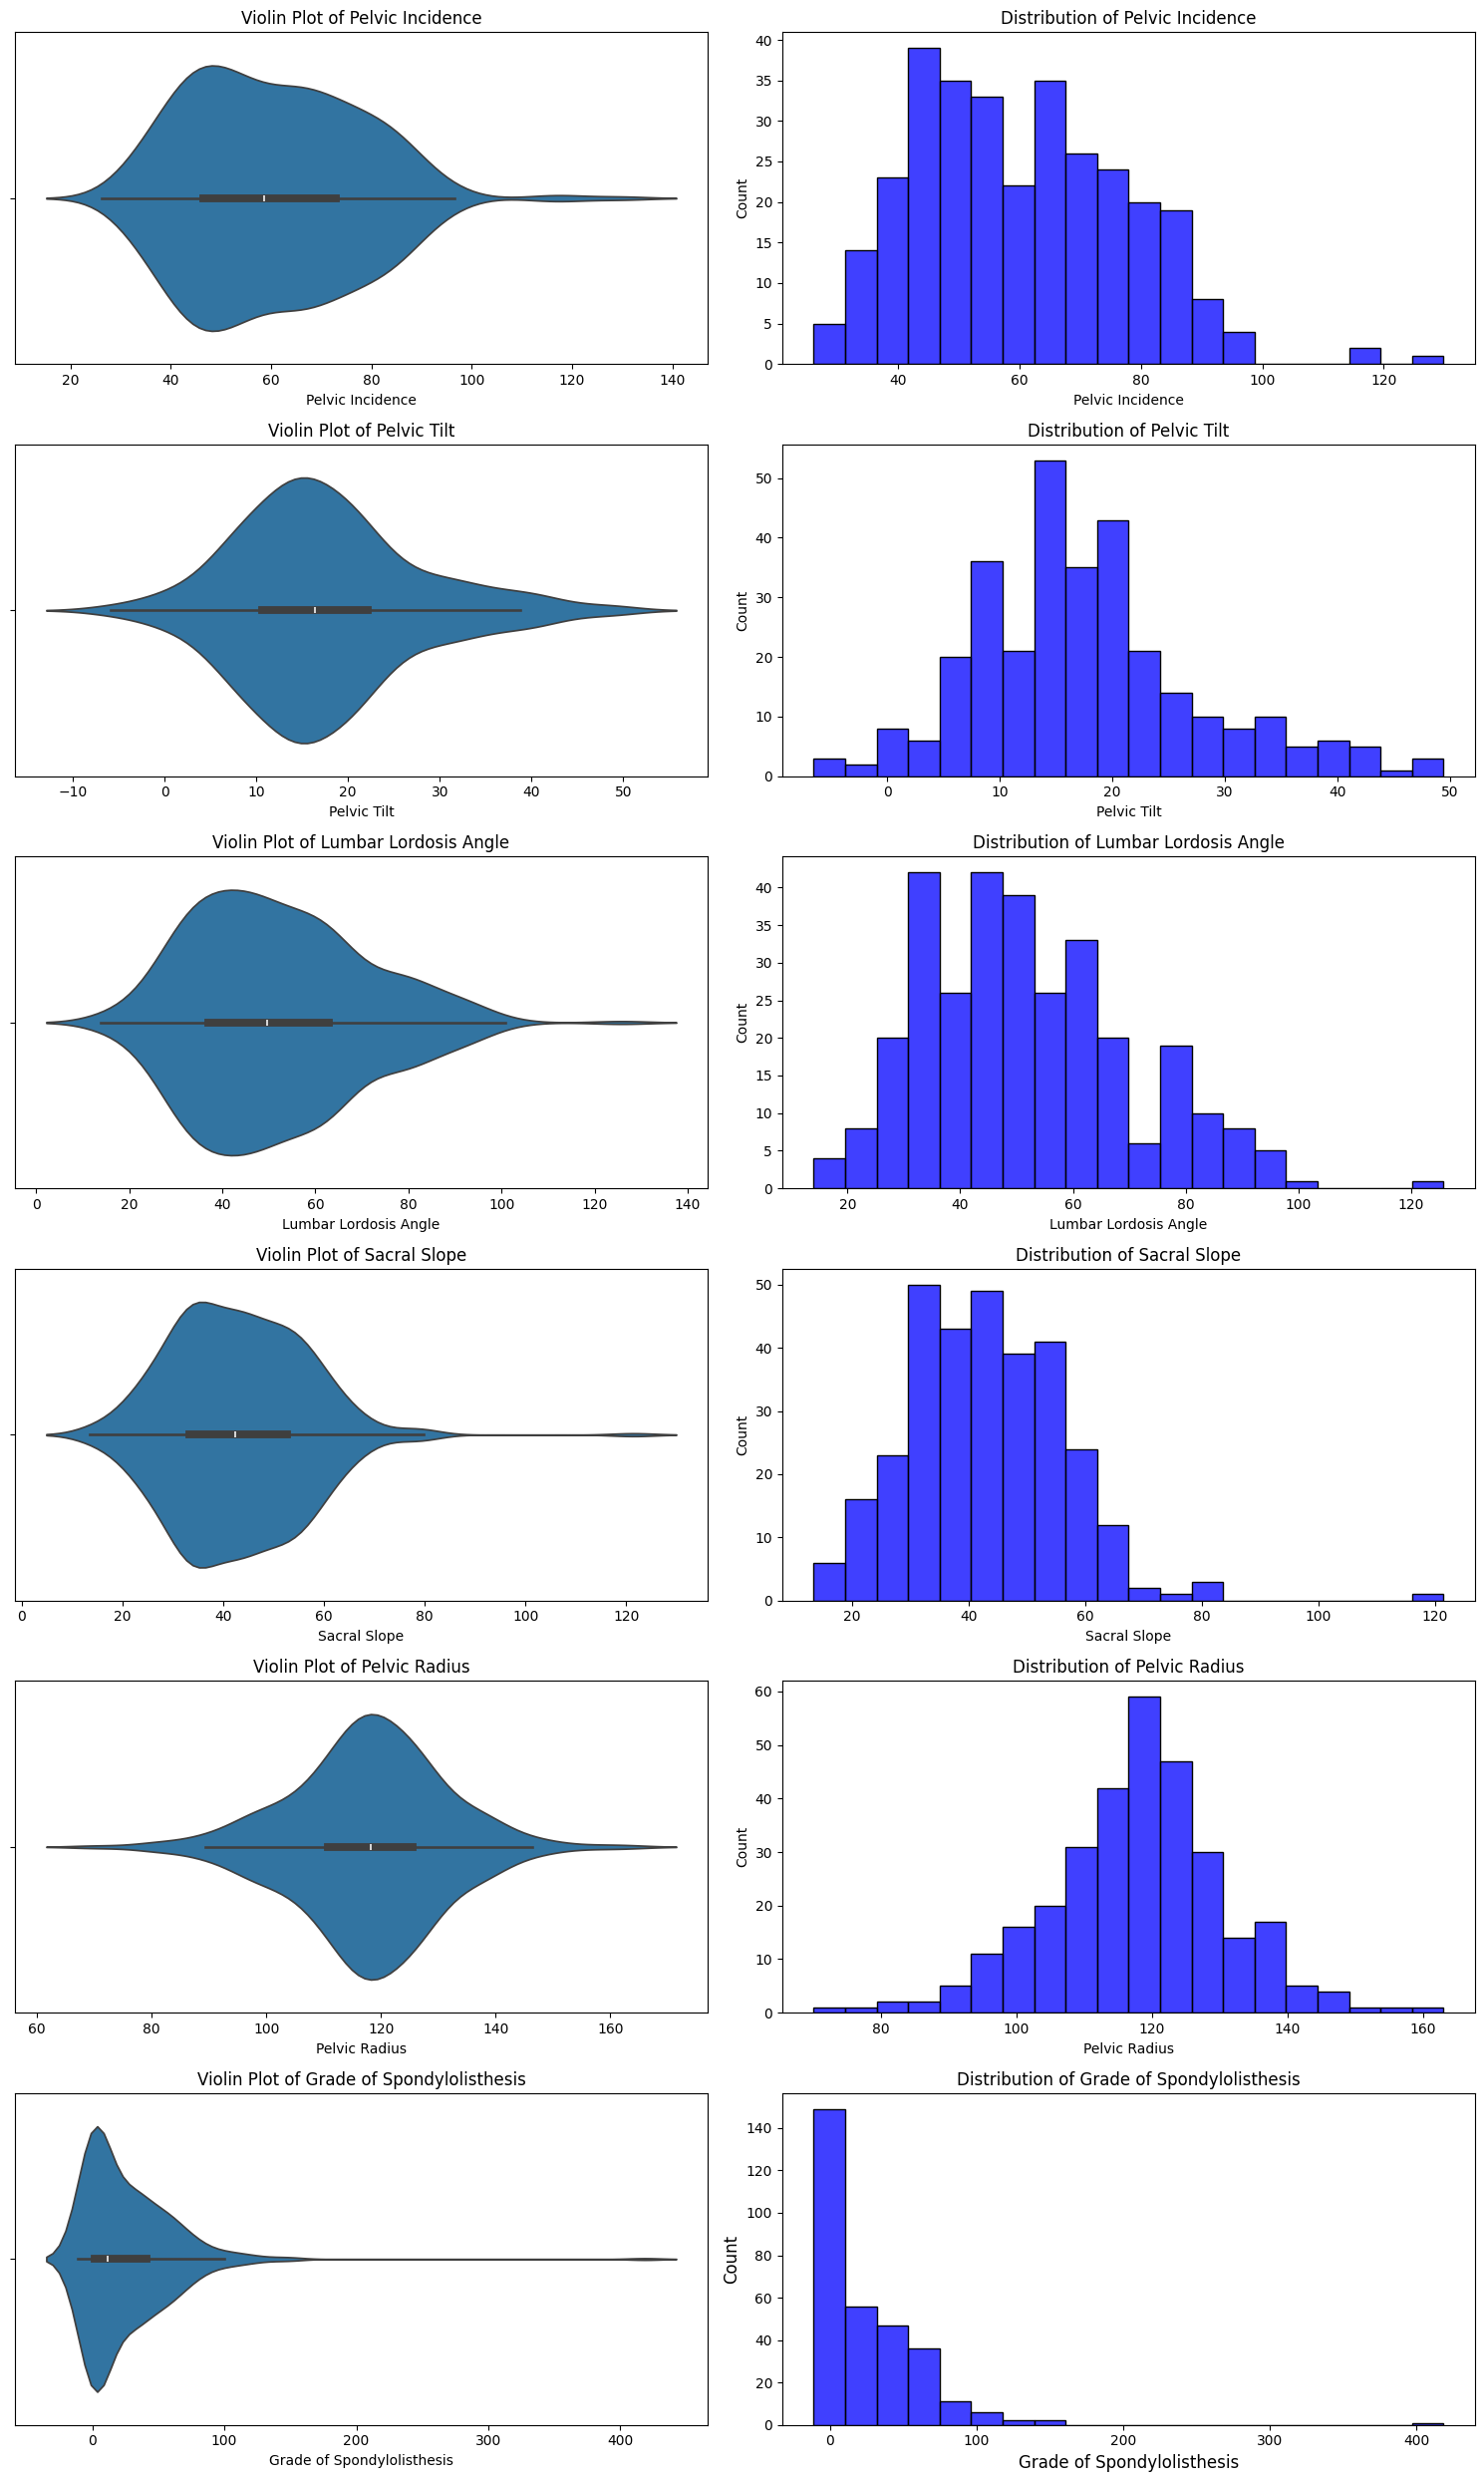

In [11]:
feature_columns = [
            'Pelvic Incidence',
            'Pelvic Tilt',
            'Lumbar Lordosis Angle',
            'Sacral Slope',
            'Pelvic Radius',
            'Grade of Spondylolisthesis'
        ]

fig, ax = plt.subplots(len(feature_columns),2, figsize=(15,25))

for idx, col in enumerate(feature_columns):
    ax[idx][0].set_title(f"Violin Plot of {col}")
    sns.violinplot(x=df[col], ax=ax[idx][0])

    sns.histplot(df[col], bins=20, color="blue", ax=ax[idx][1])
    ax[idx][1].set_title(f"Distribution of {col}")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)

fig.tight_layout()
plt.show()

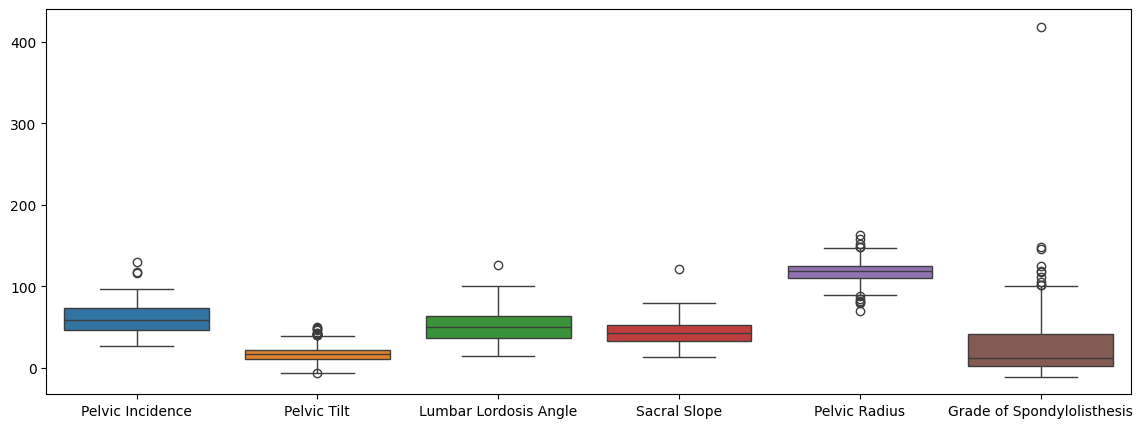

In [12]:
plt.figure(figsize=(14,5))
sns.boxplot(data=df[feature_columns])
plt.show()

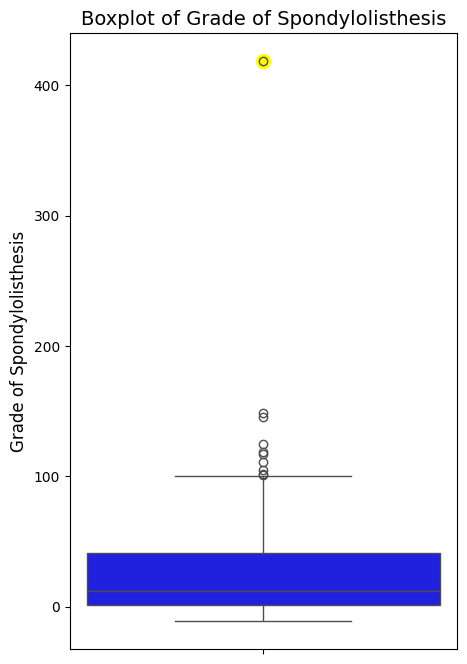

In [13]:
max = df["Grade of Spondylolisthesis"].max()

plt.figure(figsize=(5, 8))
sns.boxplot(y=df["Grade of Spondylolisthesis"], color="blue")

# Highlighting extreme outlier
plt.scatter(0, max, color="yellow", s=100)

plt.title("Boxplot of Grade of Spondylolisthesis", fontsize=14)
plt.ylabel("Grade of Spondylolisthesis", fontsize=12)
plt.show()

In [14]:
# Creating function to determine number of outliers 

df_numeric = df.iloc[:, :-1]

def count_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Outlier thresholds- if a value is more than 1.5 times the IQR away from the quartiles, it is an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Separating counts for low and high outliers
    low_outliers = (data < lower_bound).sum()
    high_outliers = (data > upper_bound).sum()
    
    return pd.Series({"Low Outliers": low_outliers, "High Outliers": high_outliers, "Total Outliers": low_outliers + high_outliers})

# Applying function to all numerical columns(so excluding Class)
outlier_counts = df_numeric.apply(count_outliers)

print("Outlier counts for each variable:")
outlier_counts

Outlier counts for each variable:


,Pelvic Incidence,Pelvic Tilt,Lumbar Lordosis Angle,Sacral Slope,Pelvic Radius,Grade of Spondylolisthesis
Low Outliers,0,1,0,0,6,0
High Outliers,3,12,1,1,5,10
Total Outliers,3,13,1,1,11,10


In [15]:
# Counting number of outliers per row
outlier_counts = df_numeric.apply(count_outliers)

outlier_mask = (df_numeric < (df_numeric.quantile(0.25) - 1.5 * (df_numeric.quantile(0.75) - df_numeric.quantile(0.25)))) | \
               (df_numeric > (df_numeric.quantile(0.75) + 1.5 * (df_numeric.quantile(0.75) - df_numeric.quantile(0.25))))

# Filtering rows with at least one outlier
outliers_df = df[outlier_mask.sum(axis=1) > 0].copy()

# Adding 'Outlier Count' column (for display)
outliers_df["Outlier Count"] = outlier_mask.sum(axis=1)

print("Outliers found in the dataset:")
outliers_df[["Outlier Count", "Class"] + df_numeric.columns.tolist()]


Outliers found in the dataset:


,Outlier Count,Class,Pelvic Incidence,Pelvic Tilt,Lumbar Lordosis Angle,Sacral Slope,Pelvic Radius,Grade of Spondylolisthesis
9,1,1,36.69,5.01,41.95,31.68,84.24,0.66
51,1,1,74.43,41.56,27.70,32.88,107.95,5.00
65,1,1,83.93,41.29,62.00,42.65,115.01,26.59
71,1,1,86.90,32.93,47.79,53.97,135.08,101.72
75,3,1,70.22,39.82,68.12,30.40,148.53,145.38
76,1,1,86.75,36.04,69.22,50.71,139.41,110.86
83,1,1,81.10,24.79,77.89,56.31,151.84,65.21
84,1,1,76.33,42.40,57.20,33.93,124.27,50.13
85,1,1,45.44,9.91,45.00,35.54,163.07,20.32
95,1,1,57.52,33.65,50.91,23.88,140.98,148.75


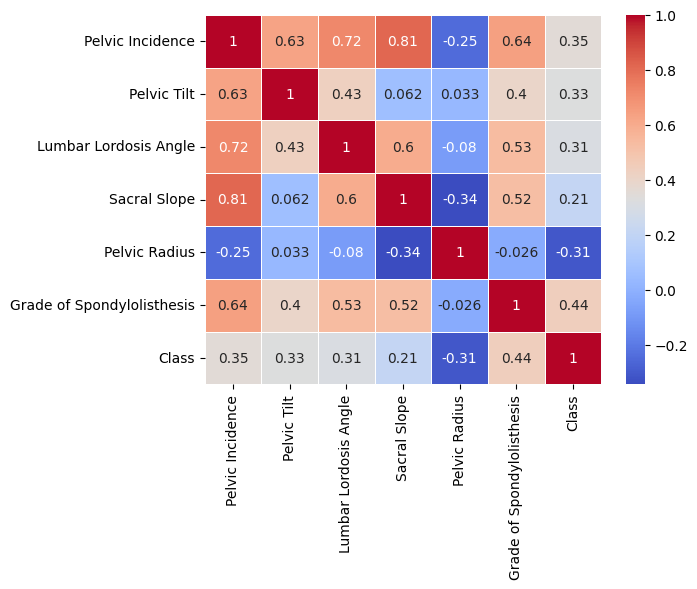

In [16]:
ax = sns.heatmap(df.corr(), linewidth=0.5, annot=True, cmap="coolwarm")
plt.show()

In [17]:
# Applying Standardisation
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=feature_columns, index=df.index)

# Adding back 'Class' column
df_scaled["Class"] = df["Class"]

# Displaying first few rows to check standardisation worked
df_scaled.head()

,Pelvic Incidence,Pelvic Tilt,Lumbar Lordosis Angle,Sacral Slope,Pelvic Radius,Grade of Spondylolisthesis,Class
0,0.147227,0.501111,-0.665128,-0.184602,-1.447831,-0.707946,1
1,-1.245707,-0.748891,-1.452763,-1.041250,-0.264028,-0.579673,1
2,0.484273,0.468085,-0.099370,0.272823,-0.897295,-0.795417,1
3,0.511586,0.711280,-0.411401,0.125820,-1.207159,-0.402332,1
4,-0.626819,-0.789923,-1.274614,-0.215943,-0.733337,-0.490069,1


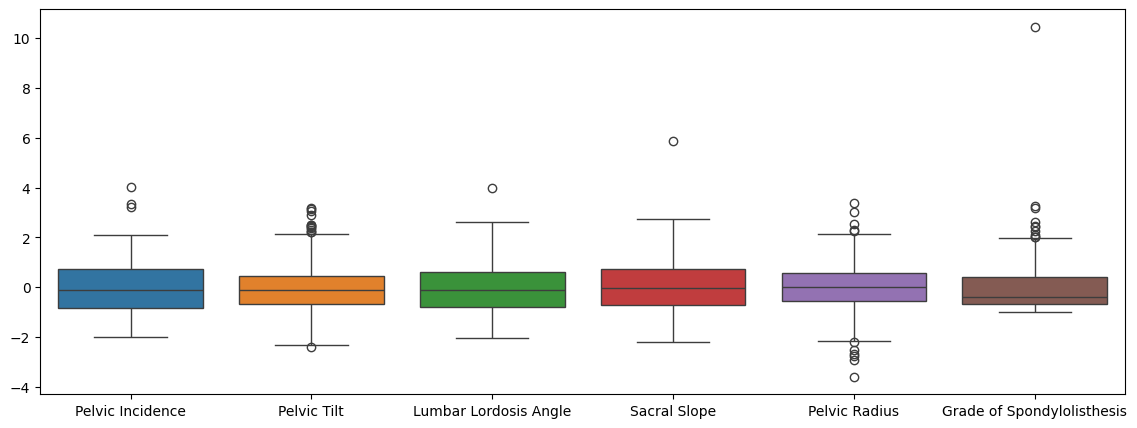

In [18]:
plt.figure(figsize=(14,5))
sns.boxplot(data=df_scaled[feature_columns])
plt.show()

In [19]:
# Applying previously defined function to standardised data
outlier_counts = df_scaled.apply(count_outliers)

print("Outlier counts for each variable:")
print(outlier_counts)

Outlier counts for each variable:
                Pelvic Incidence  Pelvic Tilt  Lumbar Lordosis Angle  \
Low Outliers                   0            1                      0   
High Outliers                  3           12                      1   
Total Outliers                 3           13                      1   

                Sacral Slope  Pelvic Radius  Grade of Spondylolisthesis  Class  
Low Outliers               0              6                           0      0  
High Outliers              1              5                          10      0  
Total Outliers             1             11                          10      0  


Due to the outliers found in the EDA, standardisation was chosen. Outliers still exist when standardisation is used but they won’t distort the scale like min-max scaling would. Min-max scaling is heavily influenced by outliers as one extreme value(e.g. the one in the Grade of Spondylolisthesis column) causes scale to be stretched and all other values to be compressed together. As clustering algorithms are distance based, standardisation prevents features with larger values from dominating the algorithm- k-means clustering and hierarchical clustering are both sensitive to outliers, as is SVM.

# Machine Learning

### Unsupervised Learning

In this project three unsupervised clustering models are used to discover structure in the data by organising them into groups whose members are similar:
- Naive K-Means Clustering 
- Model-Based Clustering (GMM)

##### K-Means Method

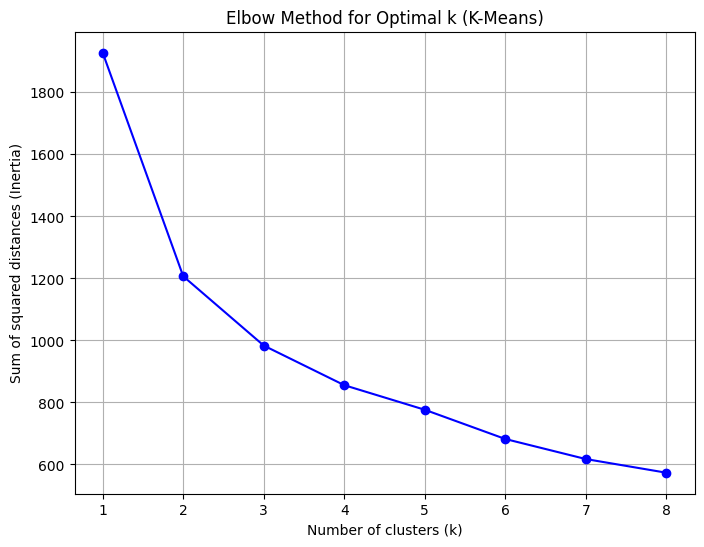

In [20]:
# Determine Optimal K using Elbow Method for K-Means
kMin = 1
kMax = 8
repsPerK = 10

kValues = np.arange(kMin, kMax + 1)
SumOfSquares = np.zeros(len(kValues))

for i, k in enumerate(kValues):
    kmeans = KMeans(n_clusters=k, n_init=repsPerK, random_state=42)
    kmeans.fit(df_scaled)
    SumOfSquares[i] = kmeans.inertia_

# Plotting the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(kValues, SumOfSquares, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.grid(True)
plt.show()

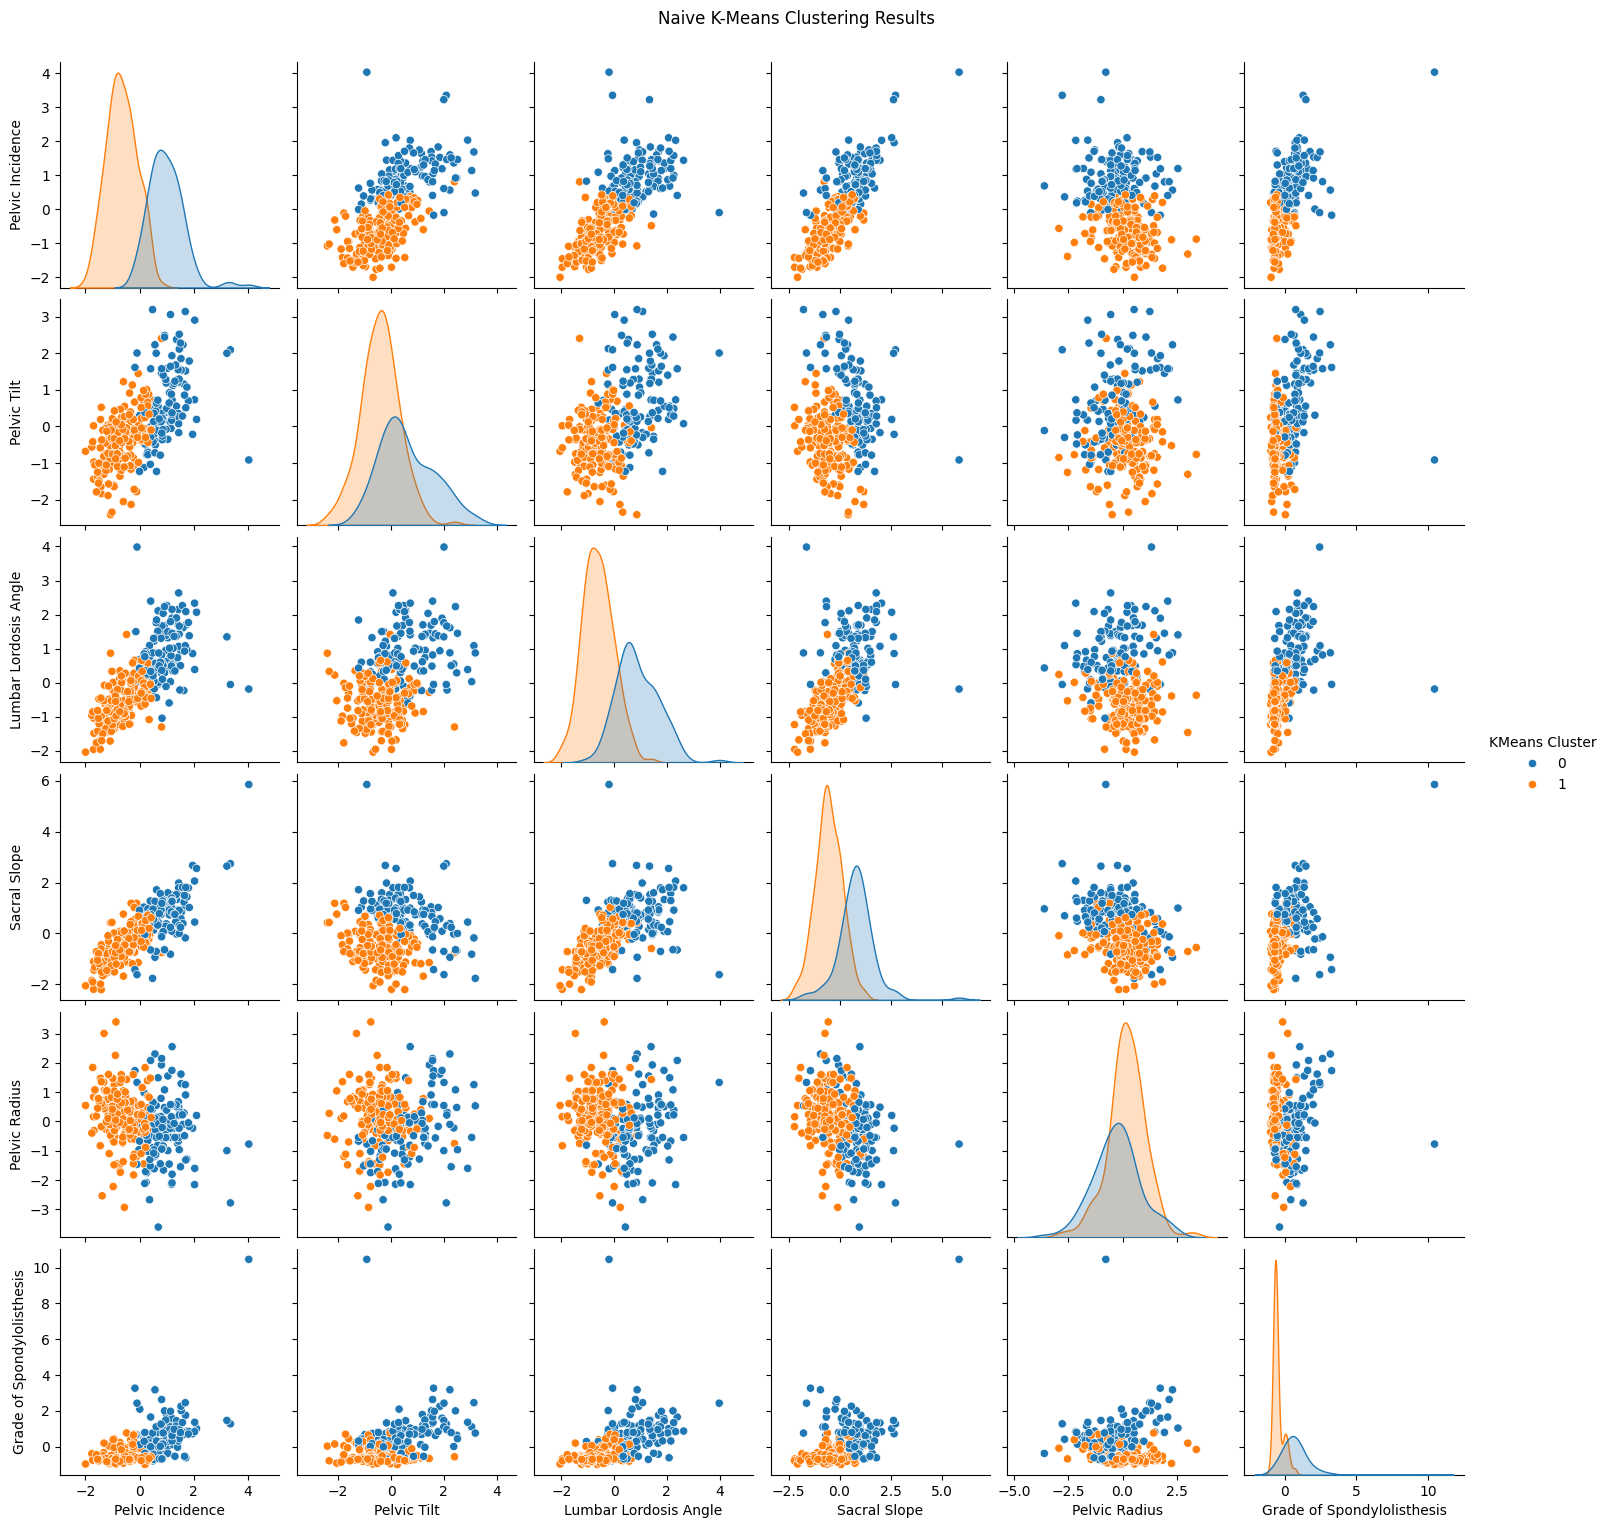

In [21]:
# Applying Naive K-Means with Optimal K
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, n_init=repsPerK, random_state=42)
df_scaled['KMeans Cluster'] = kmeans.fit_predict(df_scaled[feature_columns])

# Visualising K-Means Clustering
sns.pairplot(df_scaled.drop("Class", axis=1), hue='KMeans Cluster', diag_kind='kde')
plt.suptitle('Naive K-Means Clustering Results', y=1.02)
plt.show()

##### Model-Based Clustering (GMM)
Applying a Gaussian Mixture Model (GMM) with 2 clusters 

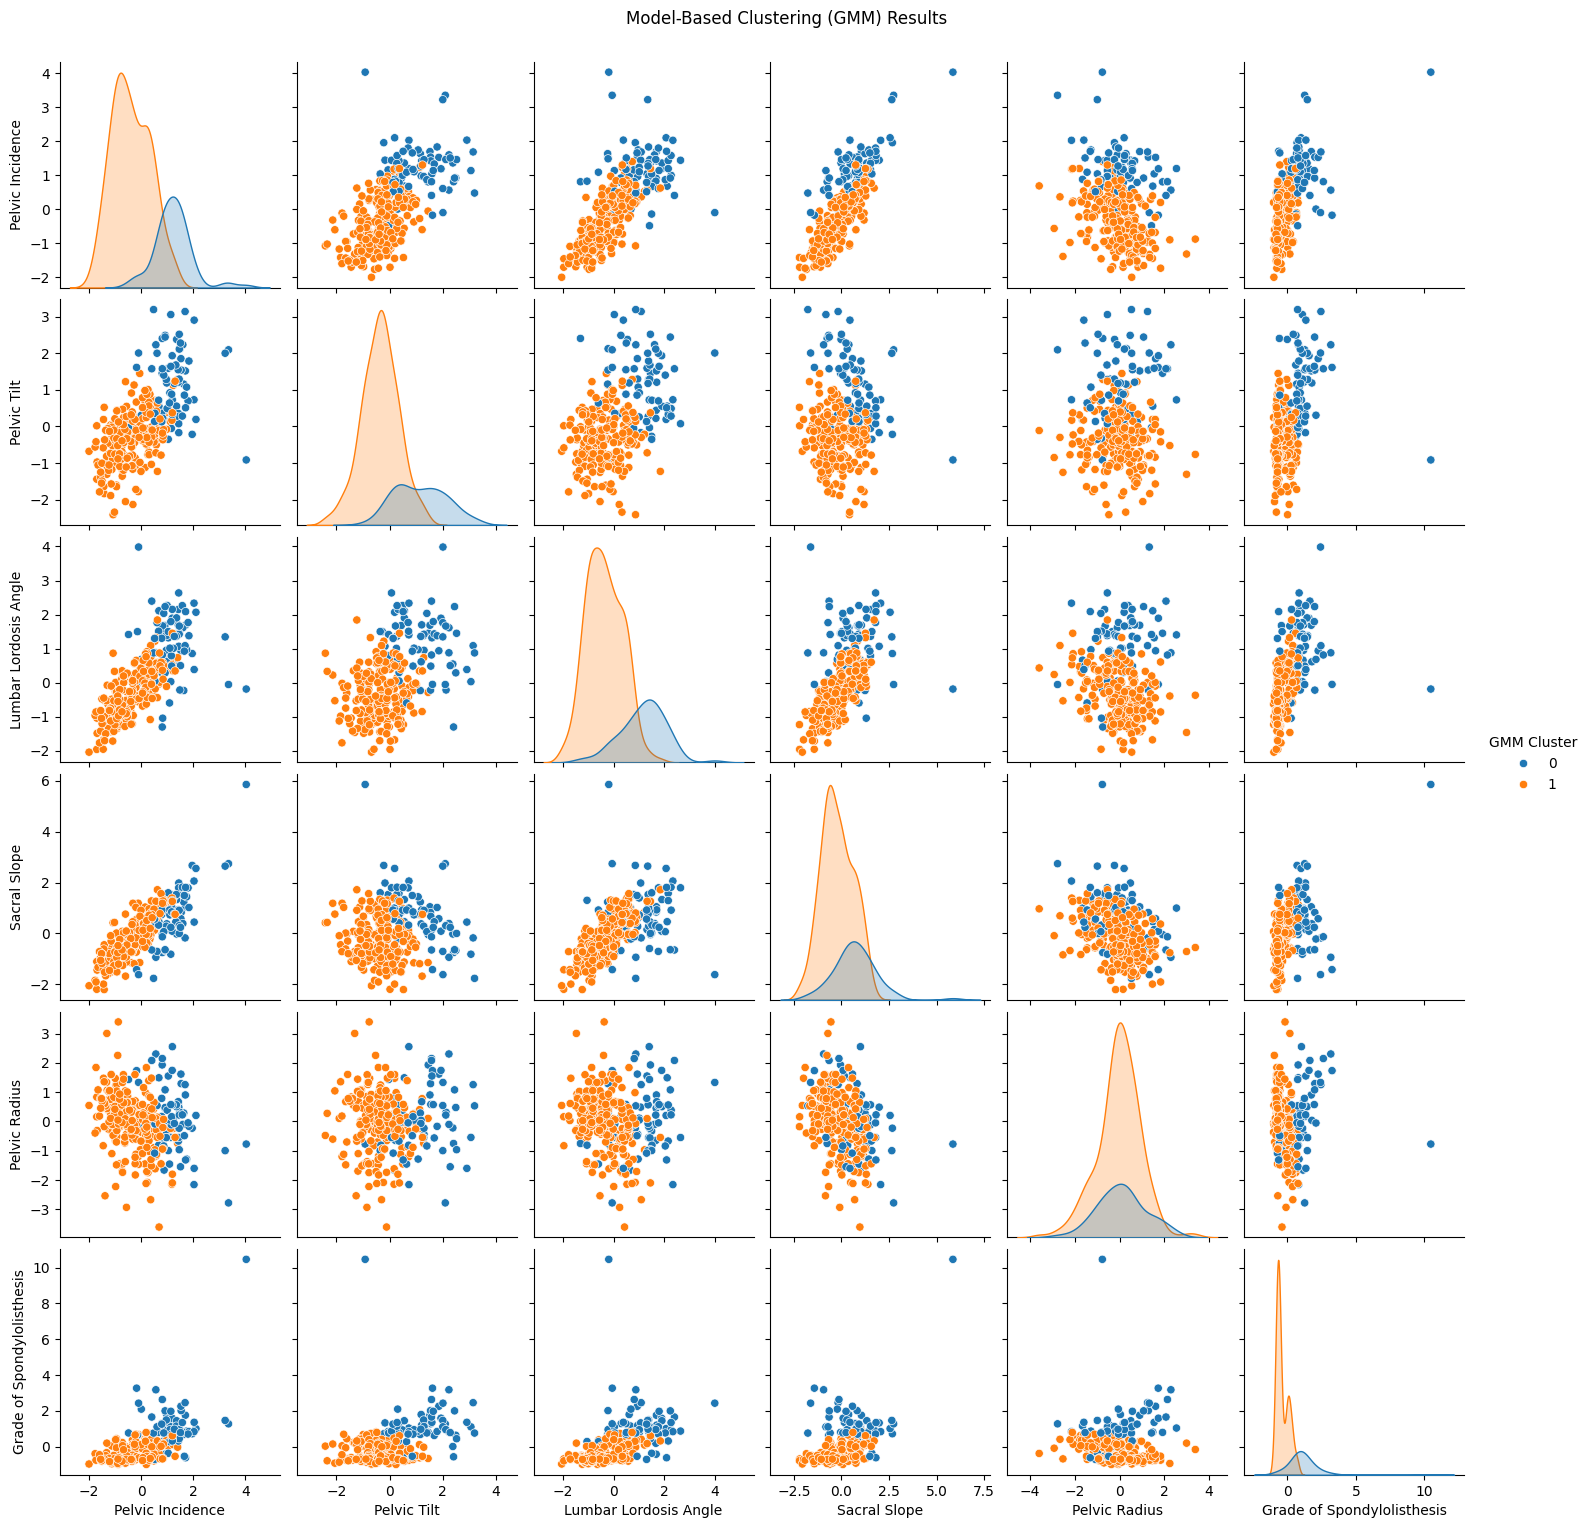

In [22]:
# Model-Based Clustering (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df_scaled['GMM Cluster'] = gmm.fit_predict(df_scaled[feature_columns])

# Visualising GMM Clustering
sns.pairplot(df_scaled.drop(["Class", "KMeans Cluster"], axis=1), hue='GMM Cluster', diag_kind='kde')
plt.suptitle('Model-Based Clustering (GMM) Results', y=1.02)
plt.show()

##### Evaluating Models using silhouette scores:

In [23]:
# Silhouette Scores to Evaluate Cluster Quality
for method in ['KMeans Cluster', 'GMM Cluster']:
    score = silhouette_score(df_scaled[feature_columns], df_scaled[method])
    print(f'Silhouette Score for {method}: {score:.4f}')

Silhouette Score for KMeans Cluster: 0.3629
Silhouette Score for GMM Cluster: 0.3656


GMM has the highest silhouette score (0.3656), suggesting it is the most effective model among the three.
The K-Means score is also decent (0.3629), indicating that this method is not far behind.

GMM scores the highest, we experiment with k values for GMM method:

In [24]:
# Experimenting with k values
for k in range(2, 6):
    gmm = GaussianMixture(n_components=k, random_state=42)
    cluster_labels = gmm.fit_predict(df_scaled[feature_columns])
    score = silhouette_score(df_scaled[feature_columns], cluster_labels)
    print(f'Silhouette Score for GMM with {k} clusters: {score:.4f}')

Silhouette Score for GMM with 2 clusters: 0.3656
Silhouette Score for GMM with 3 clusters: 0.2264
Silhouette Score for GMM with 4 clusters: 0.1942
Silhouette Score for GMM with 5 clusters: 0.1266


The highest score is with clusters, reinforcing the decision to use k = 2.
Increasing the number of clusters reduces the silhouette score, indicating poorer clustering quality with more clusters.
This behaviour suggests that the data might not naturally separate into more than 2 clusters.

In [25]:
clusters = ["KMeans Cluster", "GMM Cluster"]

for cls_type in clusters:
    print(cls_type)
    total = df_scaled.shape[0]
    first_cluster = df_scaled[df_scaled[cls_type]==1].shape[0]
    print(f"Percentage of datapoints in first cluster: {(first_cluster/total)*100:.2f}%")
    print(f"Percentage of datapoints in second cluster: {((total - first_cluster)/total)*100:.2f}%", end="\n\n")

KMeans Cluster
Percentage of datapoints in first cluster: 59.35%
Percentage of datapoints in second cluster: 40.65%

GMM Cluster
Percentage of datapoints in first cluster: 75.81%
Percentage of datapoints in second cluster: 24.19%



### Supervised Learning

##### Scaling and Splitting Data

In [26]:
# Feature selection
X = df_scaled[feature_columns]
y = df_scaled["Class"]

In [27]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Random Forest

In [28]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=46, max_depth=3)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [29]:
# Evaluate models
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8548387096774194
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.87      0.93      0.90        42

    accuracy                           0.85        62
   macro avg       0.85      0.81      0.83        62
weighted avg       0.85      0.85      0.85        62



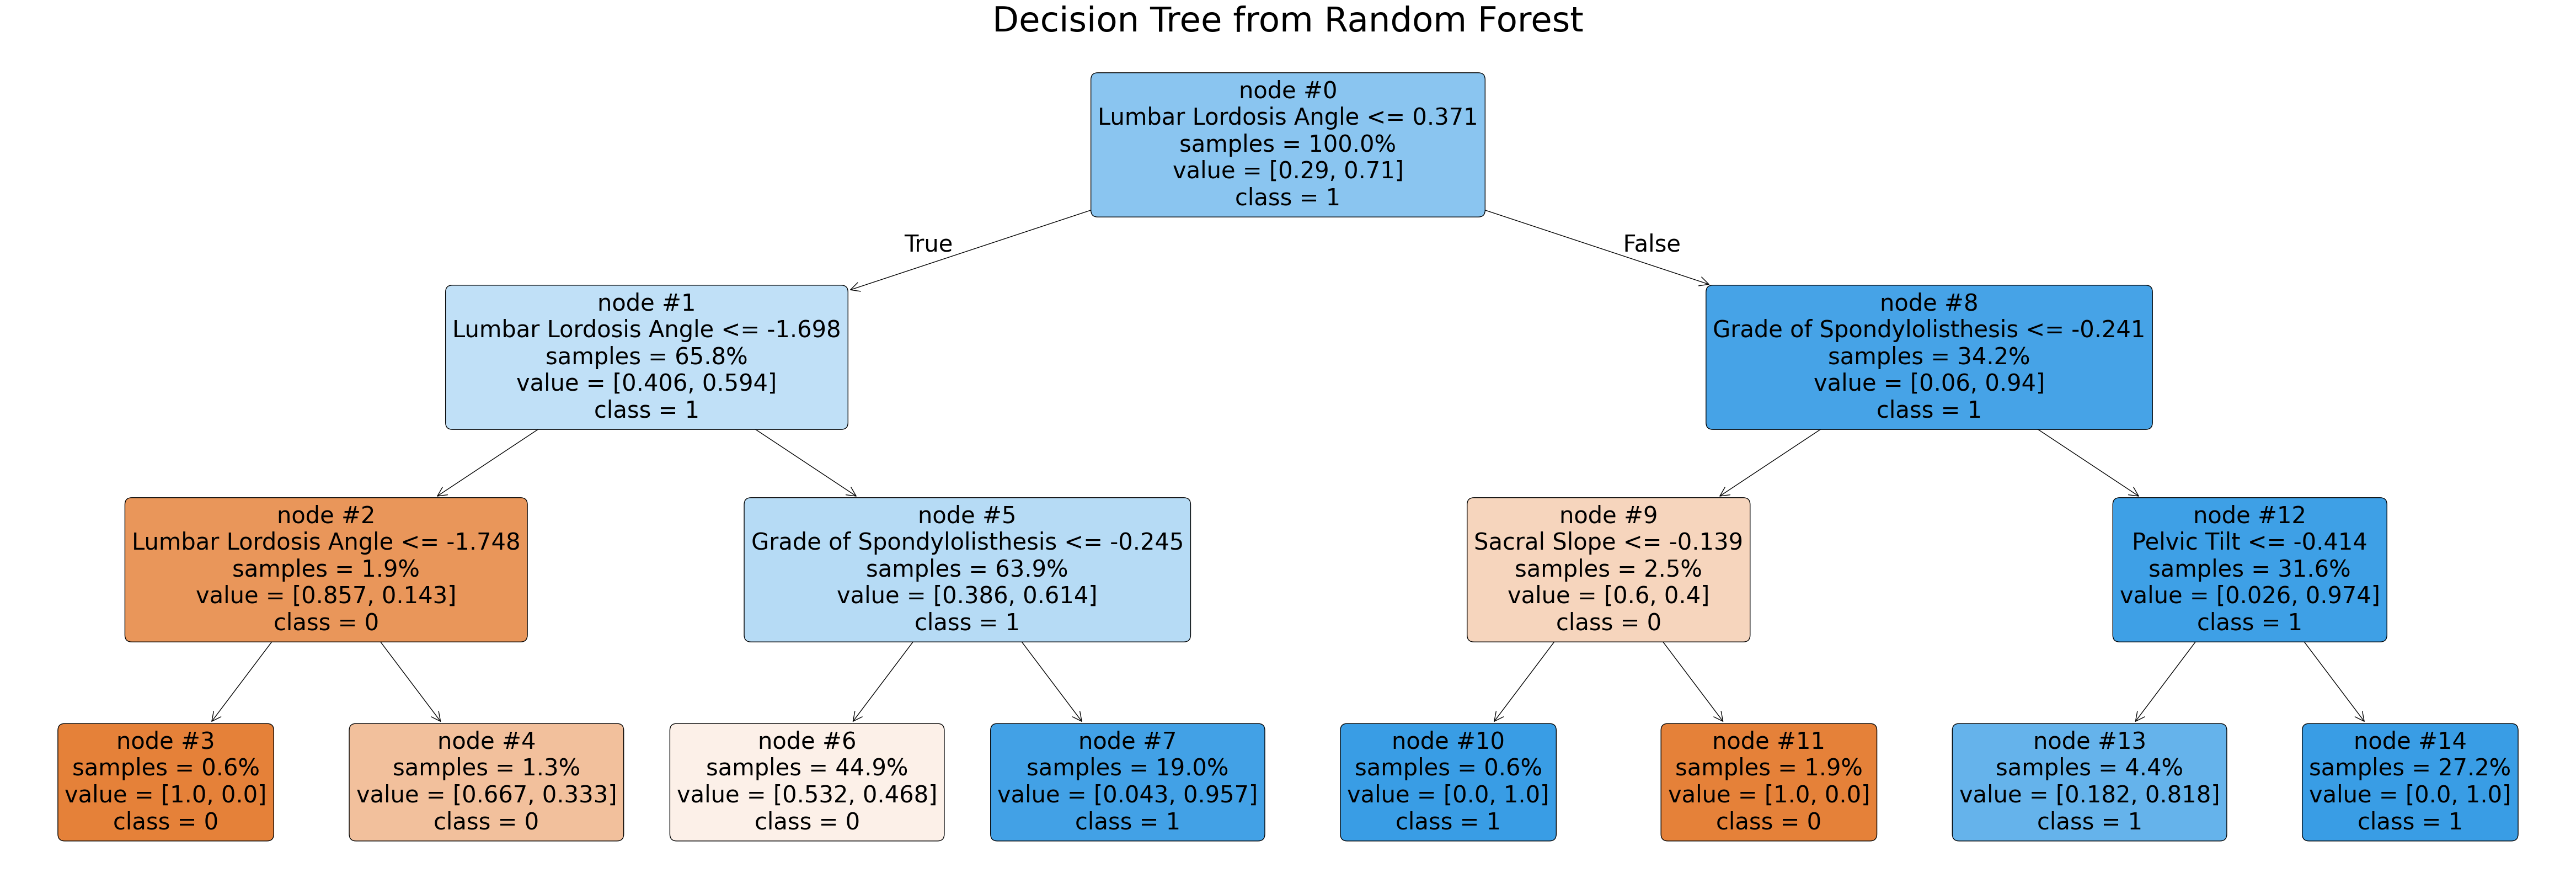

In [30]:
# Visualisation: Plot one of the trees from the Random Forest
# Set figure size
fig, ax = plt.subplots(figsize=(60, 20))
plot_tree(
    rf_model.estimators_[0], 
    feature_names=X.columns, 
    class_names=["0", "1"], 
    filled=True, 
    fontsize=30,  # Adjust font size for readability
    rounded=True,  # Rounded boxes for better aesthetics
    proportion=True,  # Show proportions instead of absolute values
    impurity=False,  # Hide impurity to make it cleaner
    node_ids=True,  # Show node IDs
    ax=ax
)
plt.title("Decision Tree from Random Forest", fontsize=45)
plt.show()

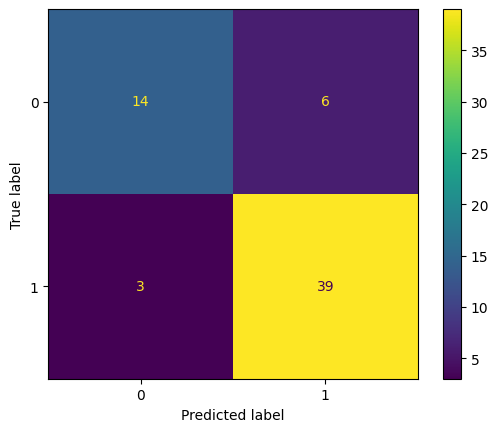

In [31]:
cm = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_, sample_weight=None, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_model.classes_)
disp.plot()
plt.show()

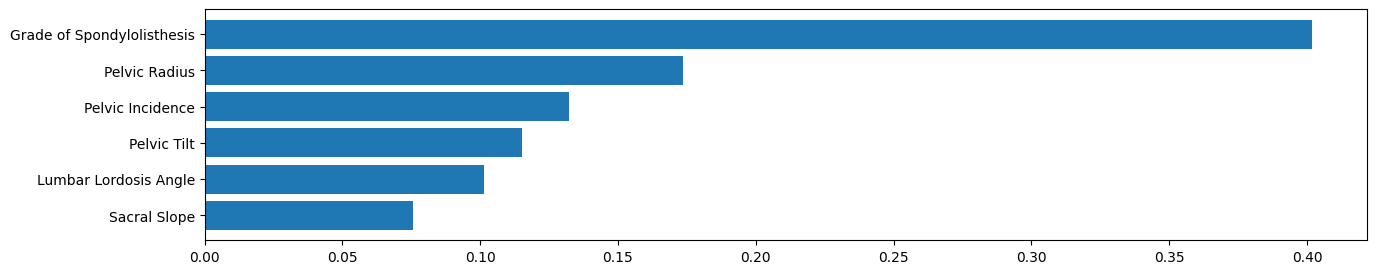

In [32]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(15,3))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

# Final Comments